
# Librería **simplenn**

[simplenn](https://github.com/facundoq/simplenn) es una librería para definir y entrenar redes neuronales basada en [Numpy](https://numpy.org/), diseñada para ser simple de _entender_. 

Aún más importante, fue diseñada para que sea simple de _implementar_. Es decir, su uso **principal** es como objeto de aprendizaje para comprender como se implementan las redes neuronales modernas en frameworks como [Keras](https://keras.io/) o [Pytorch](https://pytorch.org/). 

No obstante, también es simple para _utilizar_. Por ejemplo, para definir y entrenar una red neuronal para clasificación con de tres capas con distintas funciones de activación, podemos escribir un código muy similar al de estos frameworks:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Arquitectura de la Red:
-------------------------------
Model Sequential_6:
Linear_15 → params: 40
Bias_15 → params: 10
ReLU_6 → params: 0
Linear_16 → params: 30
Bias_16 → params: 3
Softmax_6 → params: 0
Total parameters: 83
-------------------------------



fit:   0%|          | 0/3000 [00:00<?, ?it/s]

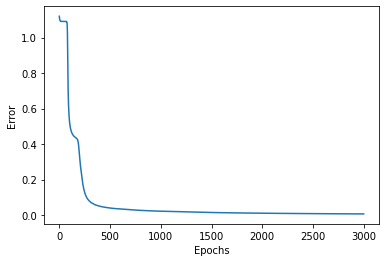

Accuracy final del modelo en el conjunto de entrenamiento: 98.00%


In [8]:
%load_ext autoreload
%autoreload 2

from simplenn import datasets

dataset_name="iris"
x,y,classes = datasets.load_classification(dataset_name)
x -= x.mean(axis=0)
x /= x.std(axis=0)
n,din=x.shape
n_classes=y.max()+1

import simplenn as sn

# Definición del modelo
layers = [sn.Linear(din,10),
          sn.Bias(10),
          sn.ReLU(),

          sn.Linear(10,n_classes),
          sn.Bias(n_classes),
          sn.Softmax()
          ]

model = sn.Sequential(layers)
print("Arquitectura de la Red:")
print(model.summary())

error = sn.MeanError(sn.CrossEntropyWithLabels())
# Algoritmo de optimización
optimizer = sn.StochasticGradientDescent(lr=0.1,epochs=3000,batch_size=32)

# Algoritmo de optimización
history = optimizer.optimize(model,x,y,error)
sn.plot.plot_history(history)


# Reporte del desempeño
y_pred = model.forward(x)
y_pred_labels = y_pred.argmax(axis=1)
print(f"Accuracy final del modelo en el conjunto de entrenamiento: {sn.metrics.accuracy(y,y_pred_labels)*100:0.2f}%")


if din ==2:
    # Visualización del modelo
    sn.plot.plot_model_dataset_2d_classification(x,y,model,title=dataset_name)

# Conocimiento previo
Para poder implementar la librería, asumimos que ya has adquirido los conceptos básicos de redes neuronales: 

* Capas
    * Capas Lineales
    * Funciones de Activación
    * Composición de capas
    * Métodos forward y backward
* Algoritmo de propagación hacia atrás (backpropagation)
* Descenso de gradiente
    * Cálculo de gradientes
    * Optimización básica por gradientes
* Cómputo/entrenamiento por lotes (batches)

También se asume conocimiento de Python y de Numpy, así como del manejo de bases de datos tabulares y de imágenes.

# Componentes de la librería

Describimos los componentes básicos de la librería utilizados en el código anterior, para proveer el contexto de los ejercicios a realizar. 




# Módulo **datasets**


El módulo `simplenn.datasets` que permite cargar algunos conjuntos de datos de prueba fácilmente, de modo de verificar y experimentar con los modelos

```python
dataset_name="study_2d_easy"
x,y,classes = datasets.load(dataset_name)
x -= x.mean(axis=0)
x /= x.std(axis=0)
n,din=x.shape
n_classes=y.max()+1
```

Para ver qué otros conjuntos de datos para clasificación o regresión tiene módulo  `datasets`, podés ejecutar `datasets.get_classification_names()` y `datasets.get_regression_names()` y obtener una lista de nombres.

In [9]:
print("Los conjuntos de datos de clasificación disponibles son:")
print(datasets.get_classification_names())
print()

print("Los conjuntos de datos de regresión disponibles son:")
print(datasets.get_regression_names())
print()

# Ejemplo de carga de otro dataset
dataset_name="study2d"
x,y,classes=datasets.load_classification(dataset_name)
print(f"Clases del dataset '{dataset_name}':")
print(classes)

Los conjuntos de datos de clasificación disponibles son:
dict_keys(['iris', 'study1d', 'study2d', 'study2d_easy'])

Los conjuntos de datos de regresión disponibles son:
dict_keys(['study1d', 'study2d', 'boston', 'wine_red', 'wine_white', 'insurance', 'real_state'])

Clases del dataset 'study2d':
['Failed', 'Passed']


# Clases y módulos de simplenn

Para usar `simplenn`, importamos la librería y la llamamos `sn` de modo que sea más legible su uso.
```python
import simplenn as sn
```

La librería tiene varias clases para crear modelos:


* Las clases `Linear`, `Bias`, que permiten crear capas con las funciones $wx$ y $x+b$ respectivamente. En estos casos, $w$ y $b$ son parámetros a optimizar. Combinando estas capas se puede formar una capa densa tradicional que calcula $wx+b$.
* Las clases`TanH`, `ReLU` y `Softmax`, que permiten crear capas con las funciones de activación de esos nombres.
* La clase `CrossEntropyWithLabels`, una capa que permite calcular el error de la red basado en entropía cruzada  _para cada ejemplo_. Esta capa además se combina con `MeanError` que permite calcular el error promedio de otra capa de error que calcula el mismo _para cada ejemplo_, como la capa `CrossEntropyWithLabels` que mencionamos, u otras como `MeanSquaredError` para el error cuadrático medio.
* La clase `Sequential` para crear redes secuenciales, donde donde la salida de cada capa es la entrada de la capa siguiente, y hay solo una capa inicial y una final.
    
Cada una de estas clases es una subclase de `Model`, y por ende permite hacer 2 operaciones:
* `forward(x)`: computa la salida `y` dada una entrada `x`. 
    * Como asunción para simplificar la librería, los modelos sólo podrán tener una entrada y una salida, que deben ser un arreglo de numpy (excepto los de error). En la práctica, veremos que esta no es una limitación importante.
* `backward(δEδy)`: computa el gradiente del error respecto a la entrada (`δEδx`), utilizando el gradiente del error respecto a la salida (`δEδy`). Si el modelo/capa tiene parámetros, también calcula el gradiente respecto a estos parámetros.
    * `backward` permite hacer una implementación desacoplada del algoritmo backpropagation.
    * Utilizando el `backward` de un modelo, se puede optimizarlo mediante descenso de gradiente.

```python
layers = [sn.Linear(din,10),
          sn.Bias(10),
          sn.ReLU(),
          sn.Linear(10,20),
          sn.Bias(20),
          sn.TanH(),
          sn.Linear(20,n_classes),
          sn.Bias(n_classes),
          sn.Softmax()
          ]
error = sn.MeanError(sn.CrossEntropyWithLabels())
model = sn.Sequential(layers)
```

Para entrenar un modelo, podemos utilizar un objeto `Optimizer`, cuyo método `optimize` permite, dados arreglos `x` e `y` y una función de error, entrenar un modelo para minimizar ese error en este conjunto de datos. 
Para este entrenamiento, debe especificarse un algoritmo de optimización. En este caso utilizamos descenso de gradiente simple con la clase `GradientDescent`, una tasa de aprendizaje de `0.1`, `100` épocas y un tamaño de lote de 16.

```python
# Algoritmo de optimización
optimizer = sn.StochasticGradientDescent(lr=0.001,epochs=1000,batch_size=32)

# Optimización
history = optimizer.optimize(model,x,y,error)
sn.plot.plot_history(history)

```



Por último, podemos utilizar y evaluar el modelo:
* El método `forward` permite obtener la salida de un modelo. 
    * Para la clase Sequential, que está compuesta por varias capas, `forward` devuelve la salida de la última capa, sin el error
    * Para un problema de clasificación, debemos calcular el argmax ya que la salida son probabilidades de clase para cada ejemplo.
* El módulo `metrics` tiene algunas funciones para evaluar métricas de desempeño del mismo.
* El módulo `plot` tiene algunas funciones para monitorear el entrenamiento del modelo (`plot_history`) y, en el caso en que el problema sea de pocas dimensiones (1 o 2), también visualizar las fronteras de decisión o la función ajustada (`plot_model_dataset_2d_classification`)

```python
sn.plot.plot_history(history)

# Reporte del desempeño
y_pred = model.forward(x)
y_pred_labels = y_pred.argmax(axis=1)
print(f"Accuracy final del modelo: {sn.metrics.accuracy(y,y_pred_labels)*100:0.2f}%")


if din ==2:
    # Visualización del modelo, solo si tiene 2 dimensiones
    sn.plot.plot_model_dataset_2d_classification(x,y,model,title=dataset_name)
```

Como habrás notado, si bien pudimos definir así la red y ejecutar el método `optimize` para pedirle al modelo que se entrene con descenso de gradiente, esta red no aprende, ya que no están implementados correctamente ninguno de los métodos correspondientes de los modelos (Bias, Linear, etc) y el optimizador StochasticGradientDescent. 

Tu objetivo es implementar las distintas capas/modelos de la librería `simplenn`, así como algunos inicializadores y algoritmos de optimización.


# Implementación de referencia 

El [repositorio de simplenn](https://github.com/facundoq/simplenn) contiene una implementación de referencia, que se enfoca en ser fácil de entender, y no en la eficiencia de cómputo.

En base al código de esa implementación de referencia, y un programa que lo procesa, se generó una versión de simplenn en donde se quitaron partes cruciales de la implementación de cada capa y otras clases.

Para poder reimplementar la librería, tendrás que buscar las líneas de código entre los comentarios `""" COMPLETAR COMIENZO """` y `""" COMPLETAR FIN """` y completar con el código correspondiente.

En todos los casos, es importante enfocarse en buscar una implementación fácil de entender y que sea correcta, y dejar de lado la eficiencia para una implementación posterior.

Si bien esta guía de implementación está en español, la implementación de la librería se ha realizado en inglés para que sea más fácil relacionar los conceptos con los de otras librerías.

Los siguientes notebooks te guiarán en la implementación de cada Modelo, tanto en el método forward y el backward, y métodos importantes de otras clases.

En caso de duda, siempre puedes consultar la [implementación de referencia](https://github.com/facundoq/simplenn/tree/main/simplenn).